# Multilayer Perceptron

***

In [1]:
pip install ucimlrepo

## Importando bibliotecas

In [2]:
# Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

# Classes do modelo
from sklearn.neural_network import MLPClassifier

# Funções de avaliação dos modelos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Aux imports for parameters search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

import warnings
warnings.filterwarnings('ignore')

### conjunto de dados

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets


dataset = pd.concat([X,y], axis=1)
dataset

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## Treinamento do modelo

Vamos estudar a implementação do [MLP no sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Primeiro, o MLPClassifier treina iterativamente, já que em cada passo de otimização, as derivadas parciais da função de custo (loss function) em relação aos parâmetros da rede (pesos e bias de cada camada) são calculadas.

O método de inicialização usado foi proposto em: Glorot, Xavier, and Yoshua Bengio. “Understanding the difficulty of training deep feedforward neural networks.” International Conference on Artificial Intelligence and Statistics. 2010.

Alguns parâmetros importantes no MLP:

- **hidden_layer_sizes**: Tupla que controla a profundidade (quantidade de camadas) e números de neurônios por cada camada escondida. Por exemplo: (100, 10,) cria uma rede com 100 neuronios na primeira camada escondida e 10 na segunda camada. O número de neurônios na entrada da rede é o número de features. A saída da ultima camada escondida tem o tamanho da quantidade de classes ou dimensões (regressão).

- **activation**: Define {‘identity’, ‘logistic’, ‘tanh’, ‘relu’} funções de ativação.
    - identity: $f(x) = x$
    - logistic: $1 / (1 + e^{-x})$
    - tanh: $tanh(x)$
    - relu: $max(0, x)$

- **batch_size**: default='auto'. Tamanho do batch de treinamento, se for mantido em "auto", $batch\_size=min(200, n\_samples)$.

- **random_state**: default= 'none'. Determina a geração de números aleatórios para inicialização dos pesos e bias, divisão de teste de treinamento se a parada antecipada for usada e amostragem em lote quando solver='sgd' ou 'adam'. Passe um int para resultados reproduzíveis em várias chamadas de função.

- **solver**: default='adam'. Algoritmo de resolução do problema de otimização de pesos. Pode assumir os seguintes valores: {‘lbfgs’, ‘sgd’, ‘adam’}

- **learning_rate**: default=’constant’ Esquema de redução de _learning_rate_. Caso seja constante, a mesma _learning_rate_ no início do treino segue até o fim.

- **max_iter**: default=200 Número máximo de iterações, caso o modelo não atinja convergência.

- **tol**: default=1e-4 (0.0001). Caso a função de custo no treinamento não melhorar mais do que _tol_, é considerado que o modelo atingiu convergência.

- **early_stopping**: default=False Se esse parâmetro for verdadeiro, separa automaticamente uma fração do dataset de treino em um dataset de validação, de tamanho validation_fraction_.

In [4]:
#Vamos usar somente duas features PetalLengthCm e PetalWidthCm
X = dataset.iloc[:,[2,3]]
y = dataset.iloc[:,[4]]

#Definindo semente
seed=42

#Mapeando os valores da classe para inteiro (para fins de visualização da região de decisão)
y = pd.factorize(dataset['class'])[0]

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
X_train.shape, X_test.shape

((105, 2), (45, 2))

**Vamos analisar os valores default**

In [5]:
model = MLPClassifier(random_state=seed)
#treinando o modelo
model.fit(X_train, y_train)

#Resultados do classificador
print(model)

#Resultados do classificador
print(classification_report(y_test, model.predict(X_test)))
# print("Treinamento score %.2f" %(model.score(X_train, y_train)))
# print("Teste score %.2f" %(model.score(X_test, y_test)))

MLPClassifier(random_state=42)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.85      0.92        13
           2       0.87      1.00      0.93        13

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



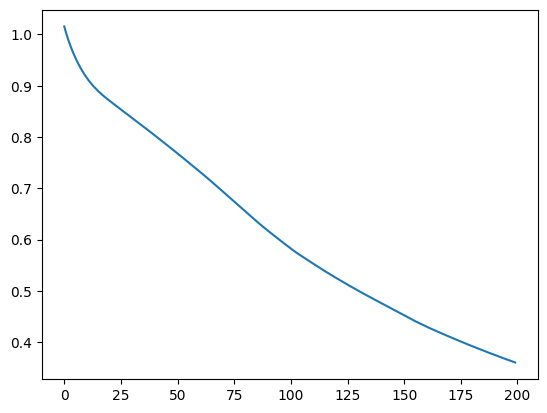

In [6]:
# como se comportou o treinamento do modelo?
plt.plot(model.loss_curve_)

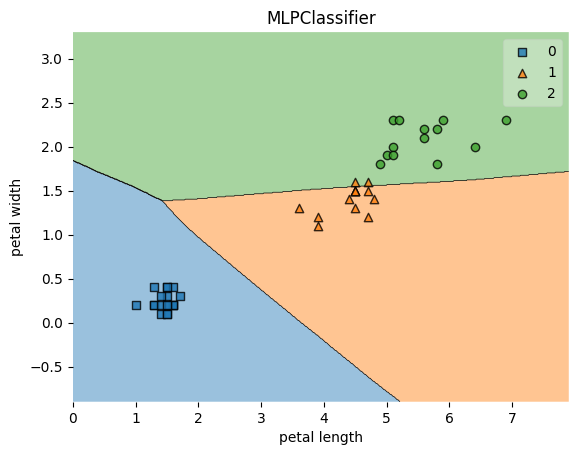

In [7]:
def show_decision_region(X, y, model):
    feature_0 = X.columns[0]
    feature_1 = X.columns[1]

    plot_decision_regions(np.array([X[feature_0].values,
                                    X[feature_1].values]).T,
                                    y, model)
    plt.xlabel(feature_0)
    plt.ylabel(feature_1)

    plt.title(model.__class__.__name__)
    plt.show()

show_decision_region(X_test, y_test, model)

## Avaliando o modelo com diferentes parâmetros

In [8]:
#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

#Separando o conjutno de treinamento em treinamento e validação (para ajuste dos parâmetros)
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=seed)

print("X_train_ shape: ", X_train_.shape)
print("X_test shape: ", X_test.shape)
print("X_val shape: ", X_val.shape)
print("\n")
print("y_train_:", pd.Series(y_train_).value_counts())
print("y_test:", pd.Series(y_test).value_counts())
print("y_val:", pd.Series(y_val).value_counts())

X_train_ shape:  (73, 2)
X_test shape:  (45, 2)
X_val shape:  (32, 2)


y_train_: 2    27
1    26
0    20
Name: count, dtype: int64
y_test: 0    19
1    13
2    13
Name: count, dtype: int64
y_val: 1    11
0    11
2    10
Name: count, dtype: int64


Talvez usar o parametro "stratify=y" no train_test_split seja uma boa ideia...

### Ajustando o modelo

**1 - número de neurônios**

In [9]:
n_neuronios = [10*i for i in range(1,21)]
print(n_neuronios)
train_score = []
val_score = []

for n in n_neuronios:
    model = MLPClassifier(hidden_layer_sizes=n, random_state=seed)
    model.fit(X_train_, y_train_)
    #Resultados do classificador
    train_score.append(model.score(X_train_, y_train_))
    val_score.append(model.score(X_val, y_val))

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


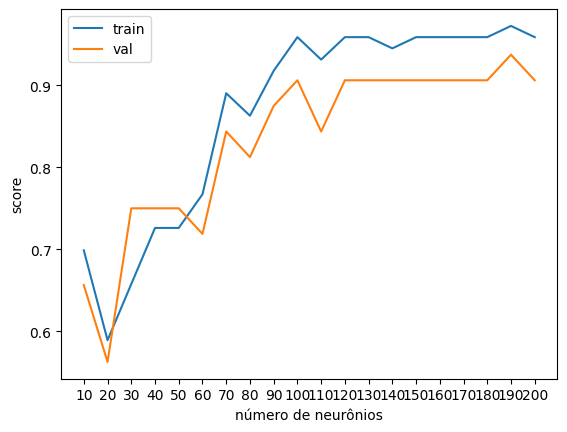

In [10]:
plt.plot(n_neuronios,train_score, label="train" )
plt.plot(n_neuronios,val_score, label="val" )
plt.xlabel("número de neurônios")
plt.ylabel("score")
plt.xticks(n_neuronios)
plt.legend()

**2 - número de camadas**

In [11]:
#qual melhor número de neurônios??
neu = 128
n_camadas = [1,2,3,4,5]

train_score = []
val_score = []

for n in n_camadas:
    camadas = [neu for i in range(n)]
    print(camadas)
    model = MLPClassifier(hidden_layer_sizes=camadas, random_state=seed)
    model.fit(X_train_, y_train_)
    #Resultados do classificador
    # print(model.n_layers_)
    train_score.append(model.score(X_train_, y_train_))
    val_score.append(model.score(X_val, y_val))

[128]
[128, 128]
[128, 128, 128]
[128, 128, 128, 128]
[128, 128, 128, 128, 128]


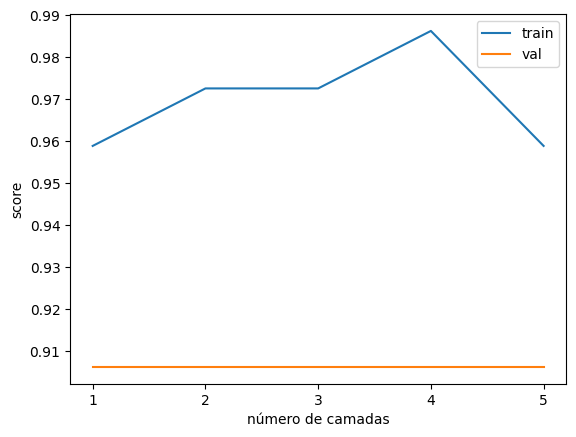

In [12]:
plt.plot(n_camadas,train_score, label="train" )
plt.plot(n_camadas,val_score, label="val" )
plt.xlabel("número de camadas")
plt.ylabel("score")
plt.xticks(n_camadas)
plt.legend()

## Randomized Search

In [13]:
#Vamos usar somente duas features mais dificeis (Sépalas)
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,[4]]

#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
print("X_train_ shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train_ shape:  (105, 4)
X_test shape:  (45, 4)


In [14]:
mlp = MLPClassifier(random_state=seed)

param_distributions = {
      'hidden_layer_sizes': [(64,), (128,), (64, 128), (32, 64, 128), (64, 128, 32)],
      'activation': ['logistic', 'tanh', 'relu'],
      'solver': ['lbfgs', 'sgd', 'adam'],
      'alpha': uniform(loc=0.0001, scale=0.01), # L2 penalty (regularization)
      'learning_rate': ['constant', 'adaptive'],
      'max_iter': randint(low=100, high=500) # Maximum number of iterations
}

random_search = RandomizedSearchCV(
        estimator=mlp,
        param_distributions=param_distributions,
        n_iter=20, # Number of parameter settings that are sampled
        cv=5,       # Number of cross-validation folds
        scoring='accuracy', # Metric to evaluate the model
        random_state=seed,
        n_jobs=-1,  # Use all available CPU cores
        return_train_score=True
        #refit
)

random_search.fit(X_train, y_train) # X_train and y_train are your training data

# Access the cv_results_ dictionary
results_dict = random_search.cv_results_

# Convert to DataFrame for better readability
results_df = pd.DataFrame(results_dict)

print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

results_df

Best parameters found: {'activation': 'logistic', 'alpha': np.float64(0.007822447692966574), 'hidden_layer_sizes': (32, 64, 128), 'learning_rate': 'adaptive', 'max_iter': 162, 'solver': 'adam'}
Best cross-validation score: 0.980952380952381


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_max_iter,param_solver,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.425702,0.239983,0.006752,0.000364,relu,0.008065,"(64, 128)",adaptive,288,lbfgs,...,0.961905,0.035635,3,0.988095,0.964286,1.000000,0.976190,0.964286,0.978571,0.013883
1,0.547728,0.156344,0.006896,0.000736,relu,0.004558,"(64, 128)",constant,187,lbfgs,...,0.952381,0.030117,10,0.988095,0.976190,1.000000,0.976190,0.988095,0.985714,0.008909
2,0.307270,0.012984,0.007048,0.000931,relu,0.000306,"(128,)",adaptive,393,sgd,...,0.952381,0.042592,10,0.952381,0.964286,0.976190,0.952381,0.952381,0.959524,0.009524
3,0.404496,0.065145,0.006632,0.000251,logistic,0.006275,"(128,)",adaptive,352,lbfgs,...,0.952381,0.042592,10,0.988095,0.976190,1.000000,0.976190,0.976190,0.983333,0.009524
4,0.279879,0.004381,0.007993,0.001067,logistic,0.005348,"(128,)",adaptive,287,adam,...,0.961905,0.035635,3,0.964286,0.976190,0.988095,0.964286,0.964286,0.971429,0.009524
5,0.740220,0.053926,0.009783,0.003668,tanh,0.001006,"(64, 128)",adaptive,154,lbfgs,...,0.942857,0.035635,13,1.000000,0.976190,1.000000,0.976190,0.976190,0.985714,0.011664
6,0.466728,0.049143,0.009966,0.005623,relu,0.008699,"(64, 128, 32)",constant,266,sgd,...,0.961905,0.046657,3,0.964286,0.976190,0.988095,0.964286,0.964286,0.971429,0.009524
7,0.549273,0.061264,0.012701,0.006065,logistic,0.009756,"(128,)",adaptive,364,sgd,...,0.752381,0.063174,19,0.702381,0.714286,0.857143,0.845238,0.773810,0.778571,0.064153
8,0.957263,0.204278,0.006493,0.000295,logistic,0.002409,"(32, 64, 128)",constant,363,adam,...,0.961905,0.035635,3,0.988095,0.976190,1.000000,0.976190,0.952381,0.978571,0.015793
9,0.737614,0.012095,0.006725,0.000231,relu,0.009193,"(32, 64, 128)",adaptive,459,sgd,...,0.961905,0.035635,3,0.976190,0.976190,0.988095,0.976190,0.976190,0.978571,0.004762


In [15]:
#Predict test data on the best random search generated model
print(classification_report(y_test, random_search.predict(X_test)))

#Retrain the model with full training data
new_mlp =  MLPClassifier(random_state=seed, **random_search.best_params_)
new_mlp.fit(X_train, y_train)
print("Retreinando o modelo explicitamente:")
print(classification_report(y_test, new_mlp.predict(X_test)))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45

Retreinando o modelo explicitamente:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45



Não é necessário retreinar o modelo explicitamente. Por default, existe um parâmetro "refit" tanto na random_search, quanto na grid_search que retreina o modelo usando todos os dados para o treinamento em vez do subconjunto utilizado no cross validation da busca pelo melhor conjunto de parâmetros.

## Um dataset mais complicado

Agora que já vimos algumas características do MLP no dataset que já conhecemos, como podemos resolver um desafio maior?

O problema das duas luas é usado para analisar a capacidade de um modelo em lidar com fronteiras de decisão complexas.

Alguns desafios:
- fronteira de decisão não linear (duas semi-luas intercaladas)
- sobreposição de classes com ruído alto

In [16]:
def plot_dataset(X, y):
    # cores e simbolos para as classses
    colors = {0: "steelblue", 1: "darkorange", 2: "mediumseagreen"}
    markers = {0: "s", 1: "^", 2:"o"}
    plt.scatter(X[y==0, 0],X[y==0, 1], c=colors[0], marker=markers[0] )

    plt.scatter(X[y==1, 0],  X[y==1, 1], c=colors[1], marker=markers[1])
    plt.show()

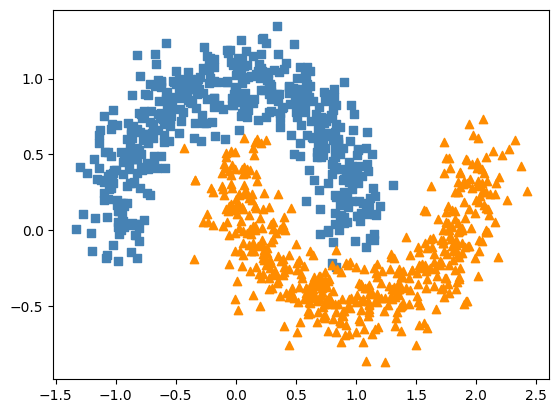

In [17]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

from matplotlib.colors import ListedColormap

# criação do dataset
X, y = make_moons(n_samples=1000, noise=0.15, random_state=42)

# visualização do dataset
plot_dataset(X, y)


In [18]:
#Separando o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, shuffle=True)
X_train.shape, X_test.shape

((700, 2), (300, 2))

MLPClassifier(hidden_layer_sizes=30, random_state=42)
Treinamento score 0.90
Teste score 0.92


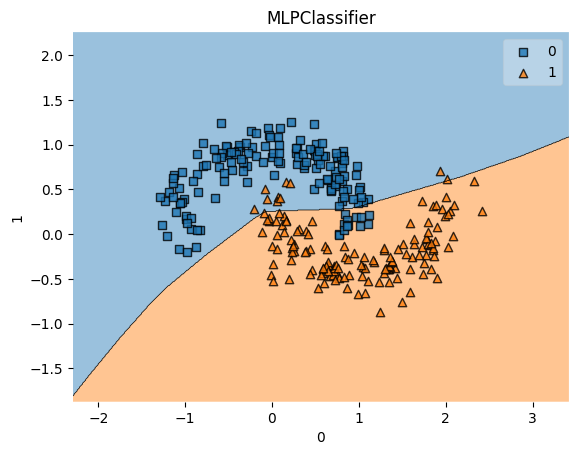

In [19]:
# vamos classificar esse dataset usando um MLP??
model_a = MLPClassifier(hidden_layer_sizes=30, random_state=seed)
#treinando o modelo
model_a.fit(X_train, y_train)
#Resultados do classificador
print(model_a)
#Resultados do classificador
print("Treinamento score %.2f" %(model_a.score(X_train, y_train)))
print("Teste score %.2f" %(model_a.score(X_test, y_test)))

show_decision_region(pd.DataFrame(X_test), y_test, model_a)

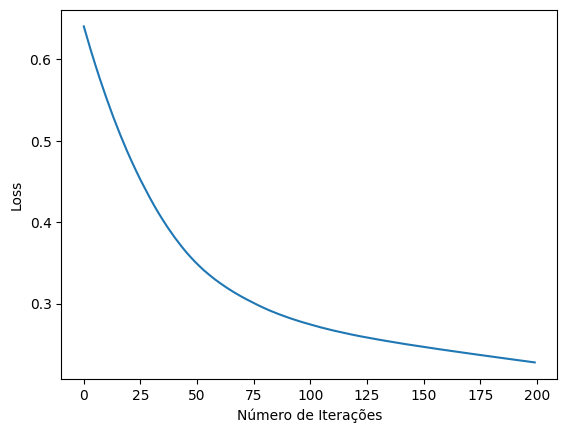

In [20]:
# como se comportou o treinamento do modelo?
plt.xlabel('Número de Iterações')
plt.ylabel('Loss')
plt.plot(model_a.loss_curve_)

Teste aumentar o número de neurônios!

Um MLP de arquitetura 10-10-10 tem desempenho melhor do que um de 1 camada com 30 neurônios?

MLPClassifier(hidden_layer_sizes=(10, 10, 10), random_state=42)
Treinamento score 0.99
Teste score 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       156
           1       1.00      0.99      0.99       144

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300

Confusion Matrix:
[[156   0]
 [  2 142]]

 Labels:[0 1] 



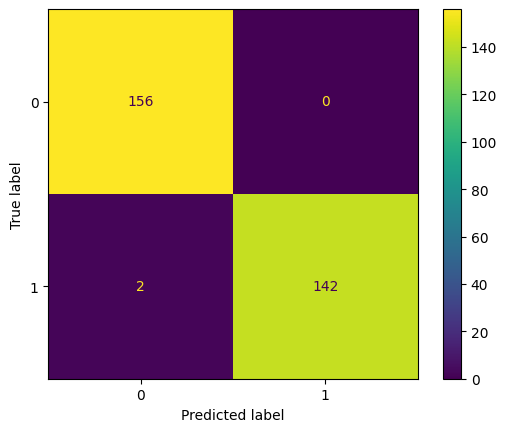

In [21]:
# vamos classificar esse dataset usando um MLP??
model_a = MLPClassifier(hidden_layer_sizes=(10, 10, 10), random_state=seed)
#treinando o modelo
model_a.fit(X_train, y_train)
#Resultados do classificador
y_pred_a = model_a.predict(X_test)
print(model_a)

#Resultados do classificador
print("Treinamento score %.2f" %(model_a.score(X_train, y_train)))
print("Teste score %.2f" %(model_a.score(X_test, y_test)))
print("Classification Report:")
print(classification_report(y_test, y_pred_a))

print("Confusion Matrix:")
# a função confusion matrix retorna uma matriz com a contagem de como cada
# uma das classes está sendo classificada corretamente ou erroneamente
cm = confusion_matrix(y_test, y_pred_a, labels=model_a.classes_)
print(cm)
print(f"\n Labels:{model_a.classes_} \n")

#display_labels - define como será a ordem das classes na matriz
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_a.classes_)
disp_cm.plot()

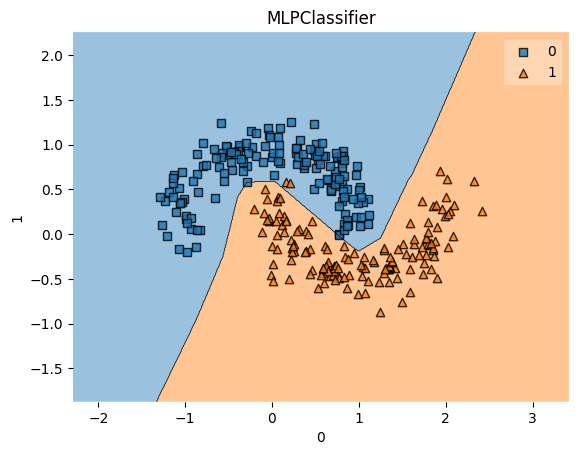

In [22]:
show_decision_region(pd.DataFrame(X_test), y_test, model_a)

E se 32-32-32?

MLPClassifier(hidden_layer_sizes=(32, 32, 32), random_state=42)
Treinamento score 0.99
Teste score 1.00
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       156
           1       1.00      0.99      1.00       144

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

[[156   0]
 [  1 143]]


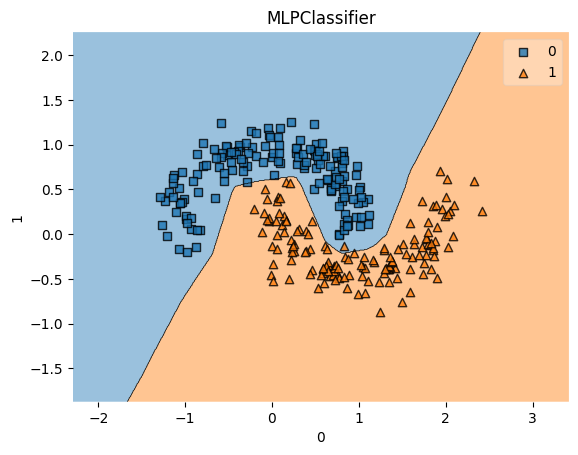

In [30]:
# vamos classificar esse dataset usando um MLP??
model_b = MLPClassifier(hidden_layer_sizes=(32, 32, 32), random_state=seed)
#treinando o modelo
model_b.fit(X_train, y_train)
#Resultados do classificador
y_pred_b = model_b.predict(X_test)
print(model_b)
#Resultados do classificador
print("Treinamento score %.2f" %(model_b.score(X_train, y_train)))
print("Teste score %.2f" %(model_b.score(X_test, y_test)))
print("Classification Report:")
print(classification_report(y_test, model_b.predict(X_test)))
cm = confusion_matrix(y_test, y_pred_b, labels=model_b.classes_)
print(cm)

show_decision_region(pd.DataFrame(X_test), y_test, model_b)

À medida que o número de neurônios e de camadas em uma rede neural aumenta, conseguimos criar regiões de decisão mais complexas!

... Cuidado com overfitting!

[Divirtam-se!](https://playground.tensorflow.org/)